In [ ]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import time

%load_ext autoreload
%autoreload 2

In [2]:
from models import FFNN

In [3]:
print("Downloading MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
X = X.astype(float)
y = y.astype(int)

In [4]:
X = np.array(X)
y = np.array(y)

In [5]:
X = X / 255.0

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_train_one_hot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.reshape(-1, 1))

In [8]:
input_size = 784  # images 28x28 = 784 pixels
hidden_sizes = [64] 
output_size = 10  # digits 0-9

In [9]:
ffnn_model = FFNN(
    layer_sizes=[input_size] + hidden_sizes + [output_size],
    activations=['relu'] * len(hidden_sizes) + ['softmax'],
    loss='categorical_cross_entropy',
    weight_init='he'
)

In [71]:
sklearn_model = MLPClassifier(
    hidden_layer_sizes=hidden_sizes,
    activation='relu',
    solver='sgd', 
    learning_rate_init=0.01,
    max_iter=10,
    random_state=42
)

In [10]:
print("\nTraining custom FFNN model...")
start_time = time.time()
ffnn_history = ffnn_model.train(
    X_train, y_train_one_hot,
    batch_size=32,
    learning_rate=0.01,
    epochs=10,
    verbose=1
)
ffnn_training_time = time.time() - start_time
print(f"Custom FFNN training time: {ffnn_training_time:.2f} seconds")


Training custom FFNN model...
Epoch 1/10, Train Loss: 0.6484
Epoch 2/10, Train Loss: 0.3428
Epoch 3/10, Train Loss: 0.2955
Epoch 4/10, Train Loss: 0.2661
Epoch 5/10, Train Loss: 0.2442
Epoch 6/10, Train Loss: 0.2264
Epoch 7/10, Train Loss: 0.2115
Epoch 8/10, Train Loss: 0.1989
Epoch 9/10, Train Loss: 0.1876
Epoch 10/10, Train Loss: 0.1776
Custom FFNN training time: 22.94 seconds


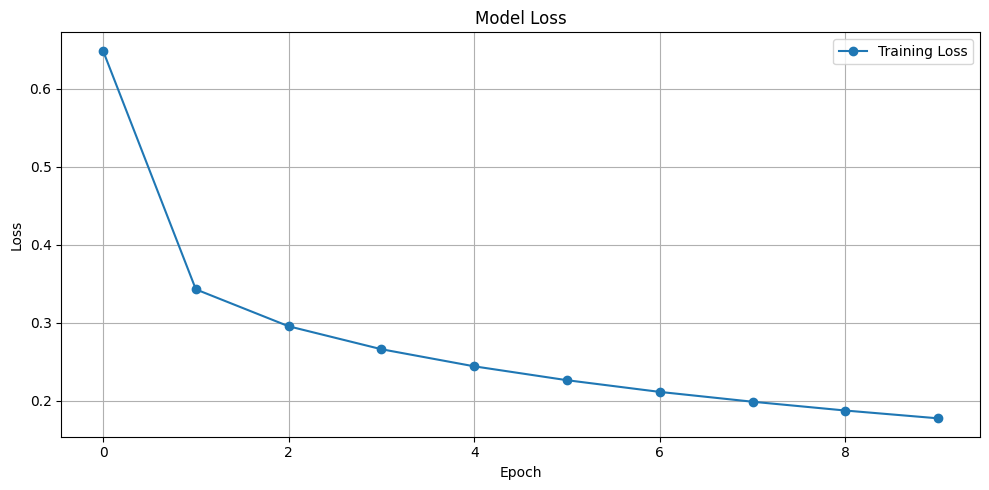

{'train_loss': [0.6484175555007332,
  0.34280289078181875,
  0.2955192983922518,
  0.26611345580943474,
  0.2442187215878623,
  0.22644542320194658,
  0.21145316388095586,
  0.19888288742650248,
  0.18760338777376773,
  0.17761229430305434],
 'val_loss': []}

In [12]:
ffnn_model.plot_loss(ffnn_history)

In [11]:
ffnn_predictions = ffnn_model.predict(X_test)
ffnn_pred_classes = np.argmax(ffnn_predictions, axis=1)
ffnn_accuracy = accuracy_score(y_test, ffnn_pred_classes)
ffnn_accuracy

0.9469285714285715

In [75]:
print("\nTraining sklearn MLPClassifier...")
start_time = time.time()
sklearn_model.fit(X_train, y_train)
sklearn_training_time = time.time() - start_time
print(f"sklearn MLPClassifier training time: {sklearn_training_time:.2f} seconds")


Training sklearn MLPClassifier...
sklearn MLPClassifier training time: 4.23 seconds


C:\Users\Shafi\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.



In [76]:
sklearn_predictions = sklearn_model.predict(X_test)
sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)
sklearn_accuracy

0.9530714285714286

### Coba coba dataset lain

In [77]:
import pandas as pd
df = pd.read_csv('./data-coba-coba/dataset1.csv', index_col='id')
df.head()

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
9046     Male  67.0             0              1          Yes        Private   
51676  Female  61.0             0              0          Yes  Self-employed   
31112    Male  80.0             0              1          Yes        Private   
60182  Female  49.0             0              0          Yes        Private   
1665   Female  79.0             1              0          Yes  Self-employed   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
9046           Urban             228.69  36.6  formerly smoked       1  
51676          Rural             202.21   NaN     never smoked       1  
31112          Rural             105.92  32.5     never smoked       1  
60182          Urban             171.23  34.4           smokes       1  
1665           Rural             174.12  24.0     never smoked       1

In [78]:
# KNNeighbour
from sklearn.neighbors import KNeighborsRegressor


def knn_imputer(df, target_feat):
  df= df.copy()

  numeric_df= df.select_dtypes(include=[np.number])
  non_empty_feature= numeric_df.loc[:, numeric_df.isna().sum() == 0].columns

  X_train= numeric_df.loc[numeric_df[target_feat].isna() == False, non_empty_feature]
  y_train= numeric_df.loc[numeric_df[target_feat].isna() == False, target_feat]
  X_test= numeric_df.loc[numeric_df[target_feat].isna() == True, non_empty_feature]

  knn = KNeighborsRegressor()
  knn.fit(X_train, y_train)

  y_pred = knn.predict(X_test)

  df.loc[df[target_feat].isna() == True, target_feat] = y_pred

  return df

target_feat = [col for col in df.columns if df[col].isnull().sum()!=0]

for col in target_feat:
    df = knn_imputer(df, col)

In [79]:
cat_df = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_df = ['age', 'avg_glucose_level', 'bmi']

In [80]:
# Apply log transformation
df['avg_glucose_level']= np.log(df['avg_glucose_level'])
df['bmi']= np.log(df['bmi'])

In [81]:
# Drop the row with Other for gender since it's just a single instance
df = df[df['gender'] != 'Other']

# Convert categorical variables to numerical format using one hot encoding
df= pd.get_dummies(df, columns= cat_df)
for feat in df.columns:
  if df[feat].dtype == 'bool':
    df[feat]= df[feat].astype('int')

In [82]:
# Split the data into X and y
X= df.drop('stroke', axis=1)
y= df['stroke']

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 9046 to 44679
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5109 non-null   float64
 1   avg_glucose_level               5109 non-null   float64
 2   bmi                             5109 non-null   float64
 3   gender_Female                   5109 non-null   int32  
 4   gender_Male                     5109 non-null   int32  
 5   hypertension_0                  5109 non-null   int32  
 6   hypertension_1                  5109 non-null   int32  
 7   heart_disease_0                 5109 non-null   int32  
 8   heart_disease_1                 5109 non-null   int32  
 9   ever_married_No                 5109 non-null   int32  
 10  ever_married_Yes                5109 non-null   int32  
 11  work_type_Govt_job              5109 non-null   int32  
 12  work_type_Never_worked          510

In [83]:
X= X.to_numpy()
y= y.to_numpy()

In [84]:
X_train,X_test,y_train,y_test= train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42)

In [85]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [86]:
ffnn_model = FFNN(
    layer_sizes= [22] + [64, 32] + [1],
    activations=['relu'] * 2 + ['sigmoid'],
    loss='binary_cross_entropy',
    weight_init='he'
)

In [87]:
ffnn_history = ffnn_model.train(
    X_train, y_train,
    batch_size=32,
    learning_rate=0.01,
    epochs=10,
    verbose=1
)

Epoch 1/10, Train Loss: 1.6884
Epoch 2/10, Train Loss: 1.6498
Epoch 3/10, Train Loss: 1.6498
Epoch 4/10, Train Loss: 1.6494
Epoch 5/10, Train Loss: 1.6487
Epoch 6/10, Train Loss: 1.6448
Epoch 7/10, Train Loss: 0.4055
Epoch 8/10, Train Loss: 0.1991
Epoch 9/10, Train Loss: 0.1777
Epoch 10/10, Train Loss: 0.1782


In [88]:
ffnn_predictions = ffnn_model.predict(X_test)
ffnn_pred_classes = np.argmax(ffnn_predictions, axis=1)
ffnn_accuracy = accuracy_score(y_test, ffnn_pred_classes)
ffnn_accuracy

0.9452054794520548

In [90]:
ffnn_model.visualize_model()